# Cross-verification of OpenSWPC_Lab using wave number integration

2022.10.18 Kurama Okubo

This notebook shows the comparison of the waveforms associated the infinite plate model for the sake of cross-verification using [Computer Programs in Seismology](https://www.eas.slu.edu/eqc/eqccps.html)

- 2024.1.29 debugged functions and updated the notebook. Removed the tapering and high-pass filter.
- 2025.3.13 update for master plot
- 2025.3.14 evaluate error in P wave amplitude

In [1]:
import os
import obspy
from obspy import read, Stream, Trace
from scipy import signal
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import pandas as pd
import datetime
from datetime import timedelta
from tqdm import tqdm
import warnings
import matplotlib as mpl

plt.rcParams["font.family"] = "Arial"
plt.rcParams["font.size"] = 12
os.environ['TZ'] = 'GMT' # change time zone to avoid confusion in unix_tvec conversion

# Functions for this cross-verification
from AE_cross_verification_complete_func import *

plt.rcParams["font.family"] = 'Arial'
# plt.rcParams["font.sans-serif"] = "DejaVu Sans, Arial, Helvetica, Lucida Grande, Verdana, Geneva, Lucid, Avant Garde, sans-serif"
plt.rcParams["font.size"] = 12
plt.rcParams["xtick.direction"] = "in"
plt.rcParams["xtick.major.size"] = 4.75
plt.rcParams["xtick.major.width"] = 0.75
plt.rcParams["xtick.minor.size"] = 3
plt.rcParams["xtick.minor.width"] = 0.4
plt.rcParams["xtick.minor.visible"] = True

plt.rcParams["ytick.direction"] = "in"
plt.rcParams["ytick.major.size"] = 4.75
plt.rcParams["ytick.major.width"] = 0.75
plt.rcParams["ytick.minor.size"] = 3
plt.rcParams["ytick.minor.width"] = 0.4
plt.rcParams["ytick.minor.visible"] = True

plt.rcParams["savefig.transparent"] = True

plt.rcParams['axes.linewidth'] = 0.75

In [2]:
figdir = "../../figure"
if not os.path.exists(figdir):
    os.mkdir(figdir)

# Define Source Time Function (STF)

### STF for body force

In [3]:
# Compute cosine source
dt = 1e-7
TR = 5.0e-6 # set at the input file of OpenSWPC 
Ft = 8.0e-5 # [Ns] The time integral of force time history; change of momentum 
tvec_STF_bf = np.arange(np.ceil(TR/dt)) * dt 
stf_cos_bf = stf_cosine(tvec_STF_bf, TR, Ft)

In [4]:
print(f"{np.trapz(stf_cos_bf, dx=dt):.2e}") # == Ft

8.00e-05


Compute balldrop source just as a reference. Note that the diameter of ball is 1.5mm and it is dropped from 500mm, which is equivalent to the synthesized cosine force-time function.

In [5]:
# Compute Ball constants from McLaskey and Glaser 2010.
rho1 = 7781.1
cp_ball  = 5900
cs_ball  = 3230

#shear modulus
G1 = rho1 * (cs_ball **2) #[Pa]
# poisson's ratio of rock
vpvs_ball = cp_ball/cs_ball
nu1  = 0.5 * (((vpvs_ball**2) - 2.0) / ((vpvs_ball**2) - 1.0))
# Young's modulus of rock
E1 = 2.0 * G1 * (1+nu1) # [Pa]

# Rock block constants
rho2 = 2980
cp_rock  = 6200 #6919
cs_rock  = 3600 #3631

#shear modulus
G2 = rho2 * (cs_rock **2) #[Pa]
# poisson's ratio of rock
vpvs_rock = cp_rock/cs_rock
nu2  = 0.5 * (((vpvs_rock**2) - 2.0) / ((vpvs_rock**2) - 1.0))
# Young's modulus of rock
E2 = 2.0 * G2 * (1+nu2) # [Pa]

print(E1/1e9, nu1)
print(E2/1e9, nu2, G2/1e9)

R = 1.5e-3/2 # ball radius for tha case of 4m ball drop.
h = 0.500 # 0.127 #0.500  # [m] dropped 500mm for tha case of 4m ball drop.
g = 9.80665
v = np.sqrt(2*g*h)

ft_herz_mc_4m = stf_herzian_mclaskey2009(tvec_STF_bf, rho1, R, v, E1, nu1, E2, nu2)

208.7951761042903 0.28601023091343925
96.2185394034537 0.24568288854003145 38.6208


In [6]:
Nzero = 2**10
rfft_signal_bd = np.fft.rfft(ft_herz_mc_4m, Nzero)
rfft_signal_cos = np.fft.rfft(stf_cos_bf, Nzero)
rfft_freq_bd   = np.fft.rfftfreq(Nzero, dt)

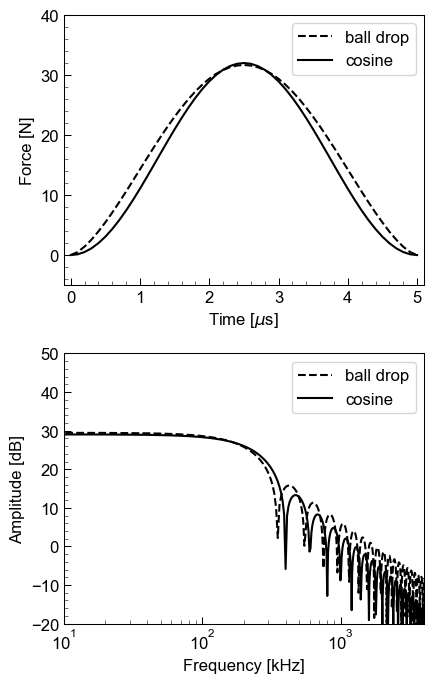

In [7]:
fig, axs = plt.subplots(2, 1, figsize=(4.5,7))

axs[0].plot(tvec_STF_bf*1e6, ft_herz_mc_4m, c="black", ls="--", label='ball drop')
axs[0].plot(tvec_STF_bf*1e6, stf_cos_bf, c="black", label='cosine')

axs[0].set_xlabel(r"Time [$\mu$s]")
axs[0].set_ylabel("Force [N]")
# axs[0].legend(fontsize=fontsize)

axs[0].set_xlim(-.1, 5.1)
axs[0].set_ylim(-5, 40)
axs[0].legend(loc=1)

pw_dB_bd = 10*np.log10(np.abs(rfft_signal_bd))
pw_dB_cos = 10*np.log10(np.abs(rfft_signal_cos))
                    
axs[1].plot(rfft_freq_bd/1e3, pw_dB_bd,"k--", label='ball drop')
axs[1].plot(rfft_freq_bd/1e3, pw_dB_cos,"k-", label='cosine')
axs[1].set_xscale('log')
axs[1].set_xlabel("Frequency [kHz]")
axs[1].set_ylabel("Amplitude [dB]")
axs[1].set_xlim(1e1, 4e3)
axs[1].set_ylim(-20, 50)
axs[1].legend(loc=1)

plt.tight_layout()
# foname = figdir+"/stf_balldrop_comparison_R{0:.1f}mm_h{1:.0f}mm.png".format(R*1e3, h*1e3)
# plt.savefig(foname, dpi=150)

### STF for double couple source with moment tensor

In [8]:
M0 = 0.4
M0hat = M0*np.sqrt(2) # We need to multiply sqrt(2) to obtain the true seismic moment of source as M0 when we normalize the moment tensor
print("M0: {:4.1f}Nm, Mw:{:4.1f}".format(M0, M02Mw(M0/np.sqrt(2))))
stf_cos_dc = stf_cosine(tvec_STF_bf, TR, 1) # to be same with the convolved stf for the case of OpenSWPC.

M0:  0.4Nm, Mw:-6.4


**NOTE** $\hat{M_0} = \sqrt{2}M_0$. We can write the seismic moment tensor $M_{ij} = \hat{M_0} m_{ij}$, where $m_{ij}$ is normalized as $\sqrt{m_{ij}^2} = 1$. Then,
 we confirm the consistency in seismic moment such that
 
 $$ \left[ \dfrac{\sum_{i,j} M_{ij}^2}{2}\right]^{\frac{1}{2}} =  \left[ \dfrac{\sum_{i,j} (\sqrt{2}M_0 m_{ij}) ^2}{2}\right]^{\frac{1}{2}} = M_0$$
 
 (Silver and Jordan, 1982; Jost and Herrmann, 1989 eq. 20).

In [9]:
# Coordinate of source-sensor distance
sensorids = ["R01", "R02", "R03"]
AEsensor_loc = {"R01":[50e-3, 70e-3, 100e-3], # we embedded the sensor 1 mm below the surface for the stability, but ignore it here.
              "R02":[100e-3, 70e-3, 0],
              "R03":[150e-3, 70e-3, 100e-3]}
source_loc=[[0, 70e-3, 0],
            [0, 0, 50e-3]]

# Read data and Synthesize waveform

## Plot Green's function of Herrmann96

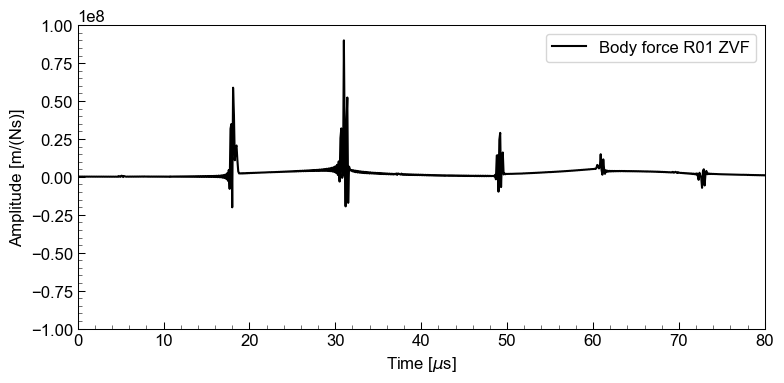

In [10]:
tr = read("../herrmann96/bf/BF_R01_11ZVF.sac", format='SAC')[0]
fig, ax = plt.subplots(1, 1, figsize=(8,4))

ax.plot(tr.times()*1e6, -tr.data, c="black", ls="-", label='Body force R01 ZVF')
ax.set_xlabel(r"Time [$\mu$s]")
ax.set_ylabel("Amplitude [m/(Ns)]")
ax.legend(loc=1)

ax.set_xlim(0, 80)
ax.set_ylim(-10e7, 10e7)

plt.tight_layout()
foname = figdir+"/GreenFunc_Herrmann96_bf_R01_ZVF.png"
plt.savefig(foname, dpi=150)

## Read Computer Program in Seismology (Herrmann 1996) analytical Green's function

## Output of CPS and the method to synthesize the velocity waveforms

The wavenumber integration modules in Computer Program in Seismology (CPS) outputs the set of time series named like `ZSS` (see APPENDIX B GREEN'S FUNCTIONS of cps330o).
We configured the process flow as follows:

```sh
hprep96 -M modelplate.d -d dfile_DC_R01R03 -HS 50e-6 -HR 99e-6 -TF -BF -ALL -V -NDEC 1
hspec96
hpulse96 -V -STEP -t -l 1 | f96tosac -B
```

Here we convolve the triangle pulse with short duration (2 time step; 0.2μs) to compute the velocity time series with option `-V`. 
We synthesized the velocity time series with the impulse-like source time function, $\hat{v}_z$, from the output of time series such as `ZSS` and the moment tensor of $\sqrt{2}m_{ij}$, where $m_{ij}$ is the normalized moment tensor such that $\sqrt{m_{ij}^2} = 1$. We can write the waveform as the convolution of Green's function and source time function as follows:

$$ \hat{v}_z(t) = G_z(t) * \hat{s}^{\text{triangle}}(t) \sim G_z(t) * \delta(t), $$ 

where $G_z(t)$ is the Green's function resulting from the summation of Green's function components and the moment tensor.  Here we can replace the stf of triangle pulse convolved during the `hpulse96` to the delta function, considering $\int \hat{s}^{\text{triangle}}(t) dt = 1$. Note that the seismic moment of this waveform is $\left[ \dfrac{\sum_{i,j} (\sqrt{2}m_{ij})^2}{2}\right]^{\frac{1}{2}} = 1$ (Silver and Jordan, 1982; Jost and Herrmann, 1989 eq. 20).

To obtain the waveform with a given source time function $S(t)$, we convolve it as follows:

$$ v_z(t) = \hat{v}_z(t) * s(t) \sim G_z(t) * s(t).$$

Note that $s(t) = \dot{M}(t)$. The seimsic moment of $v_z(t)$ is obtained as $\int_0^T s(t) dt$.


In [11]:
# evaluation of scaling factor associated with body force of Herrmann96
# 1dyne = 1e-5N
scale_fac_herrmann_bf = 1e-15*1e-2*1e5 # 1e-15 from Appendix B of the manual, 1e-2 from cm to m, 1e5 from dyne to N.
print(f"{scale_fac_herrmann_bf:4.1e}")

1.0e-12


In [12]:
# evaluation of scaling factor associated with double couple source of Herrmann96
scale_fac_herrmann_dc = 1e-20*1e-2*1e5*1e2 # 1e-20 from Appendix B of  manual, 1e-2 from cm to m in output, 1e5 from dyne to N, and 1e2 from cm to m in the input unit.
print(f"{scale_fac_herrmann_dc:4.1e}")

1.0e-15


In [13]:
sensorids

['R01', 'R02', 'R03']

In [14]:
# read sac for bf
dt_herrmann = 1e-7

st_herrmann_bf = Stream()
for sensorid in sensorids:
    st = read("../herrmann96/bf/BF_{}*ZVF.sac".format(sensorid), format='SAC')
    for tr_tmp in st: 
        tr_convolved = np.convolve(-tr_tmp.data, stf_cos_bf, mode='same') * dt_herrmann * scale_fac_herrmann_bf # the sign of trace is inverted; convolve STF; need to multiply dt 
        tr_tmp.stats.station=sensorid
        tr_tmp2 = tr_tmp.copy()
        tr_tmp2.stats.starttime = datetime.datetime(2022,10,18,8)
        tr_tmp2.data = tr_convolved
        st_herrmann_bf.append(tr_tmp2)
        

In [15]:
# read sac for dc
sensorcoord_xy = {"R01": [50, 70, -1],
                  "R02": [100, 70, +1],
                  "R03": [150, 70, -1]} #  The third indicates whether sensor is on the top or bottom side of surface; +1 with zs =0 and -1 with zs=h.

st_herrmann_dc = Stream()
for sensorid in sensorids:
    st = read("../herrmann96/dc/DC_{}*.sac".format(sensorid), format='SAC')
   
    # compute strike 
    strike_cross = sensorcoord_xy[sensorid][2] * np.rad2deg(np.arctan2(sensorcoord_xy[sensorid][1], sensorcoord_xy[sensorid][0]))
    # NOTE: As the formulation of Herrmann is defined with strike (phi) independently from the mij, we make the strike slip with 0 strike and 90 dip. 
    mij_herrmann = compute_momenttensor_lab(0, 0) 
    # synthesize the waveform
    data_herrmann = compute_synthetic_waveform_vz_herrmann96(strike_cross, M0, mij_herrmann, stf_cos_dc, st)
    tr_tmp3 = st[0].copy()
    tr_tmp3.stats.station=sensorid
    tr_tmp3.stats.channel="Vz"
    tr_tmp3.stats.starttime = datetime.datetime(2022,10,18,8)
    tr_tmp3.data = -sensorcoord_xy[sensorid][2] * scale_fac_herrmann_dc * data_herrmann # correct sign: inverted depending on the side
    st_herrmann_dc.append(tr_tmp3)


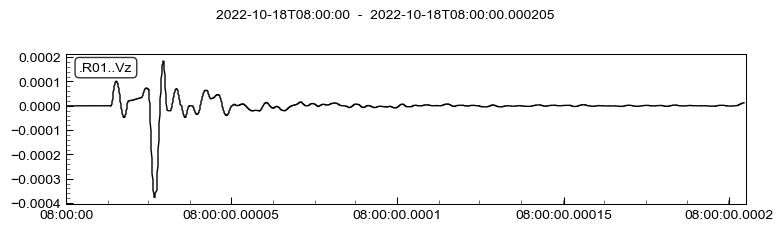

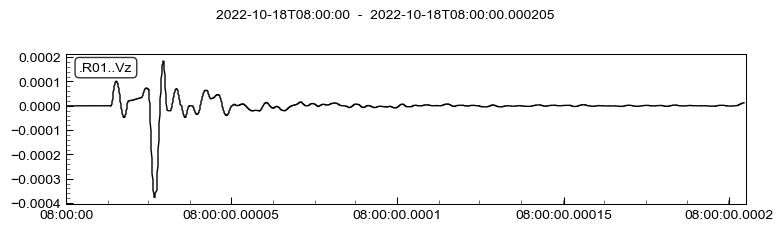

In [16]:
st_herrmann_dc[0].plot()

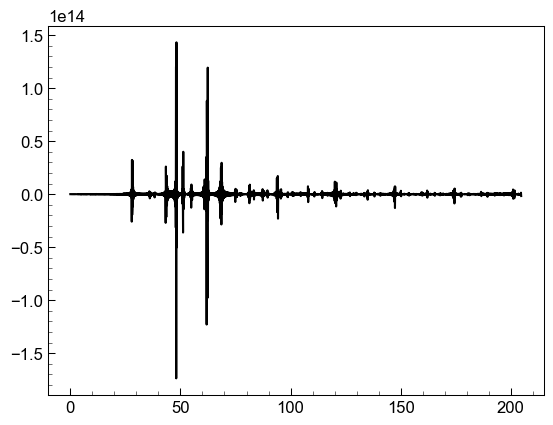

In [17]:
tr = st.select(channel="ZSS")[0]
plt.plot(tr.times()*1e6, tr.data, "k-")

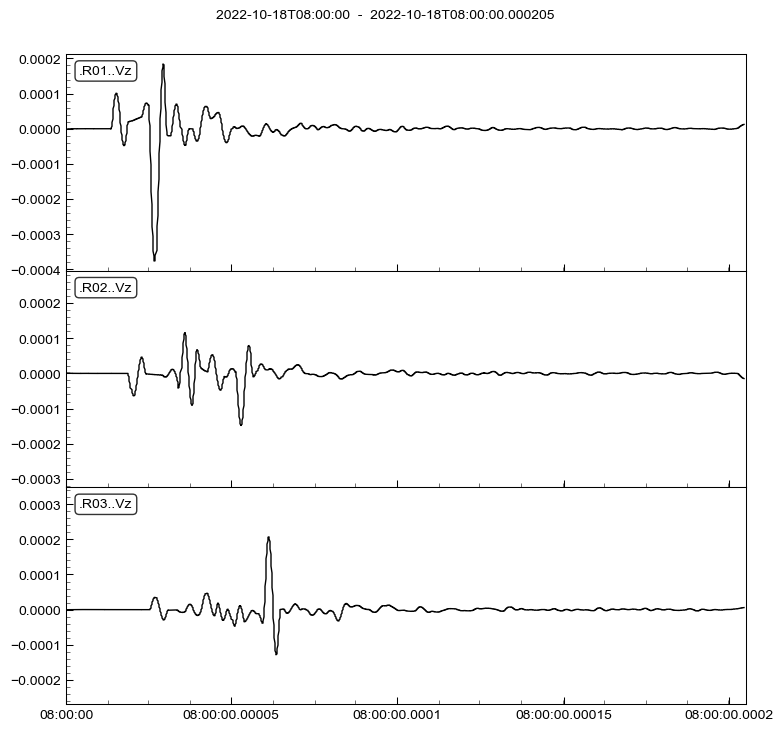

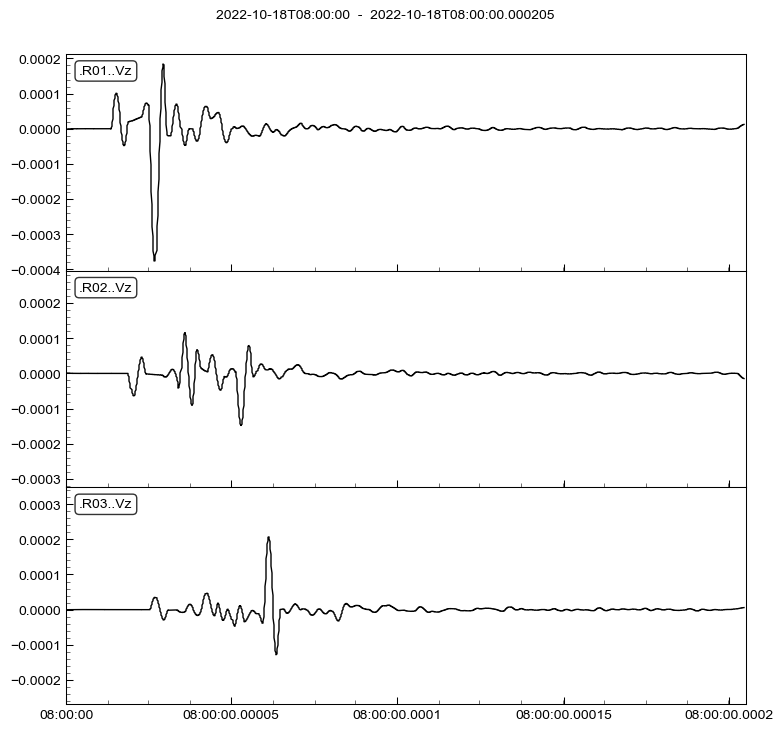

In [18]:
st_herrmann_dc.plot()

## Read OpenSWPC numerical Green's function
**NOTE:** the unit of dc output is [nm/s], following sac format.

In [19]:
st_swpc_bf = Stream()
st_swpc_dc = Stream()

mij_swpc = compute_momenttensor_lab(0, 0) # it's on the absolute coordinate of lab

for sensorid in sensorids:
    
    # body force
    st_tmp0 = read("../openswpc/{}/out/green/{}/*__{:08d}__*.sac".format(sensorid, sensorid, 0), format="SAC")
    tr_tmp0 = st_tmp0.select(channel="G_Vz_fz_")[0]
    tr_tmp0.stats.starttime = datetime.datetime(2022,10,18,8)
    tr_tmp0.data *= Ft # scale with Ft of source time function
    tr_tmp0.dist = np.linalg.norm(np.array(AEsensor_loc[sensorid]) - np.array(source_loc[0]))
    st_swpc_bf.append(tr_tmp0)
    
    # double couple
    st_tmp1 = read("../openswpc/{}/out/green/{}/*__{:08d}__*.sac".format(sensorid, sensorid, 1), format="SAC")
    st_tmp_dc1 = st_tmp1.select(channel="G_Vz_m??")
    data_swpc = compute_synthetic_waveform_vz_openswpc(M0hat, mij_swpc, st_tmp_dc1)
    # store trace
    tr_tmp1 = st_tmp_dc1[0].copy()
    tr_tmp1.stats.starttime = datetime.datetime(2022,10,18,8)
    tr_tmp1.data = data_swpc
    tr_tmp1.dist = np.linalg.norm(np.array(AEsensor_loc[sensorid]) - np.array(source_loc[1]))
    tr_tmp1.stats.channel = "Vz"
    st_swpc_dc.append(tr_tmp1)

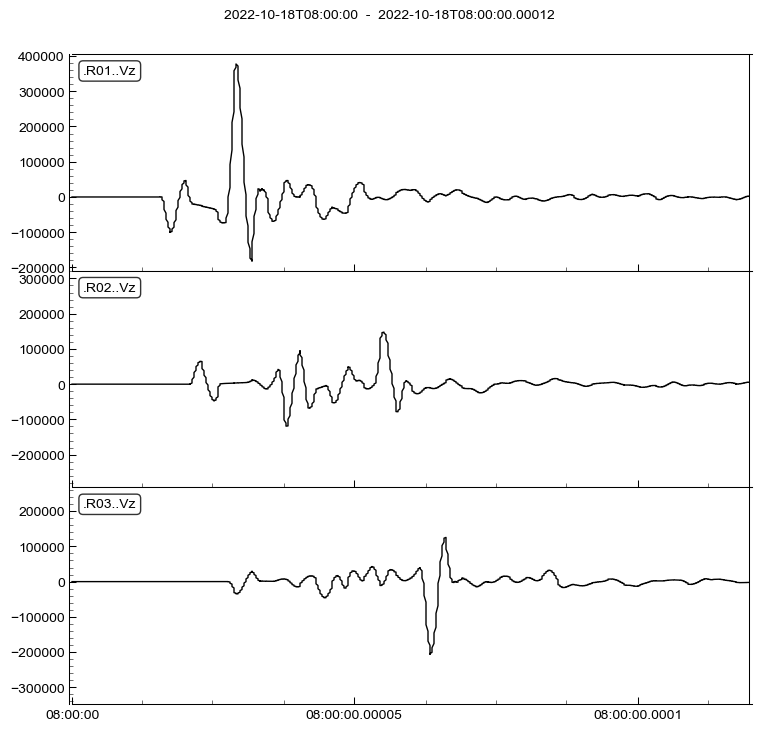

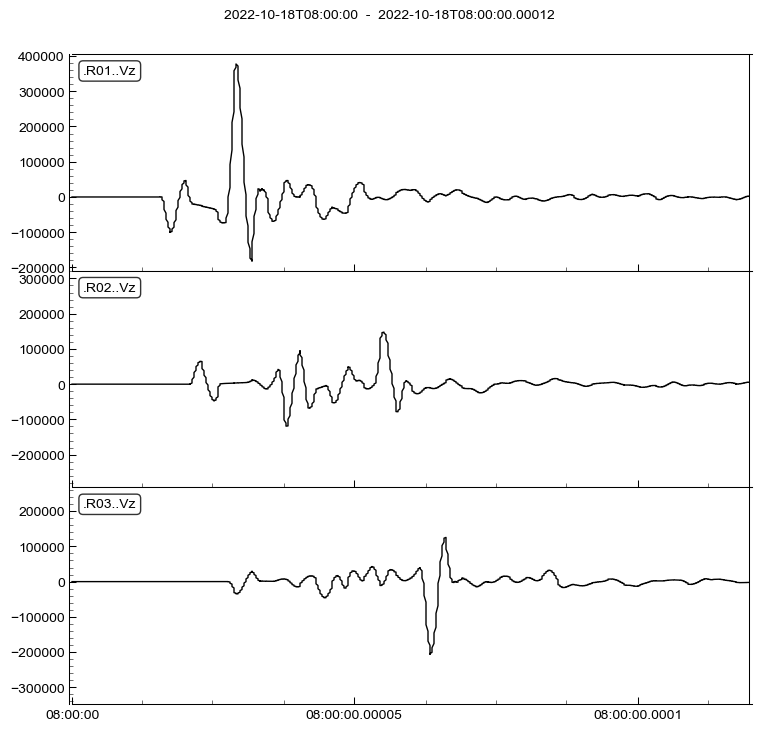

In [20]:
st_swpc_dc.plot()

# Time shift and trim the data
We shift the time with half duration of STF on hsu and herrmann's analytical solutions due to the timing of pulse on Green's function, and then trim the data.

In [21]:
Ndata = st_swpc_bf[0].stats.npts
tshift = TR/2 # as the convolution is centered at the spike
Ntshift = int(np.floor(tshift/dt))-1

In [22]:
offset_winlen = 10

for i in range(3):

    # herrmann96
    dtmp3 = np.hstack((np.zeros(Ntshift, ), st_herrmann_bf[i].data - np.mean(st_herrmann_bf[i].data[:offset_winlen])))  
    st_herrmann_bf[i].data = dtmp3[:Ndata]
    dtmp4 = np.hstack((np.zeros(Ntshift, ), st_herrmann_dc[i].data - np.mean(st_herrmann_dc[i].data[:offset_winlen])))  
    st_herrmann_dc[i].data = dtmp4[:Ndata]

    # OpenSWPC
    st_swpc_bf[i].data = st_swpc_bf[i].data[:Ndata] - np.mean(st_swpc_bf[i].data[:offset_winlen])
    st_swpc_dc[i].data = st_swpc_dc[i].data[:Ndata] - np.mean(st_swpc_dc[i].data[:offset_winlen])

# Plot comparison: all traces

## Plot comparison with Wavenumber integration

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


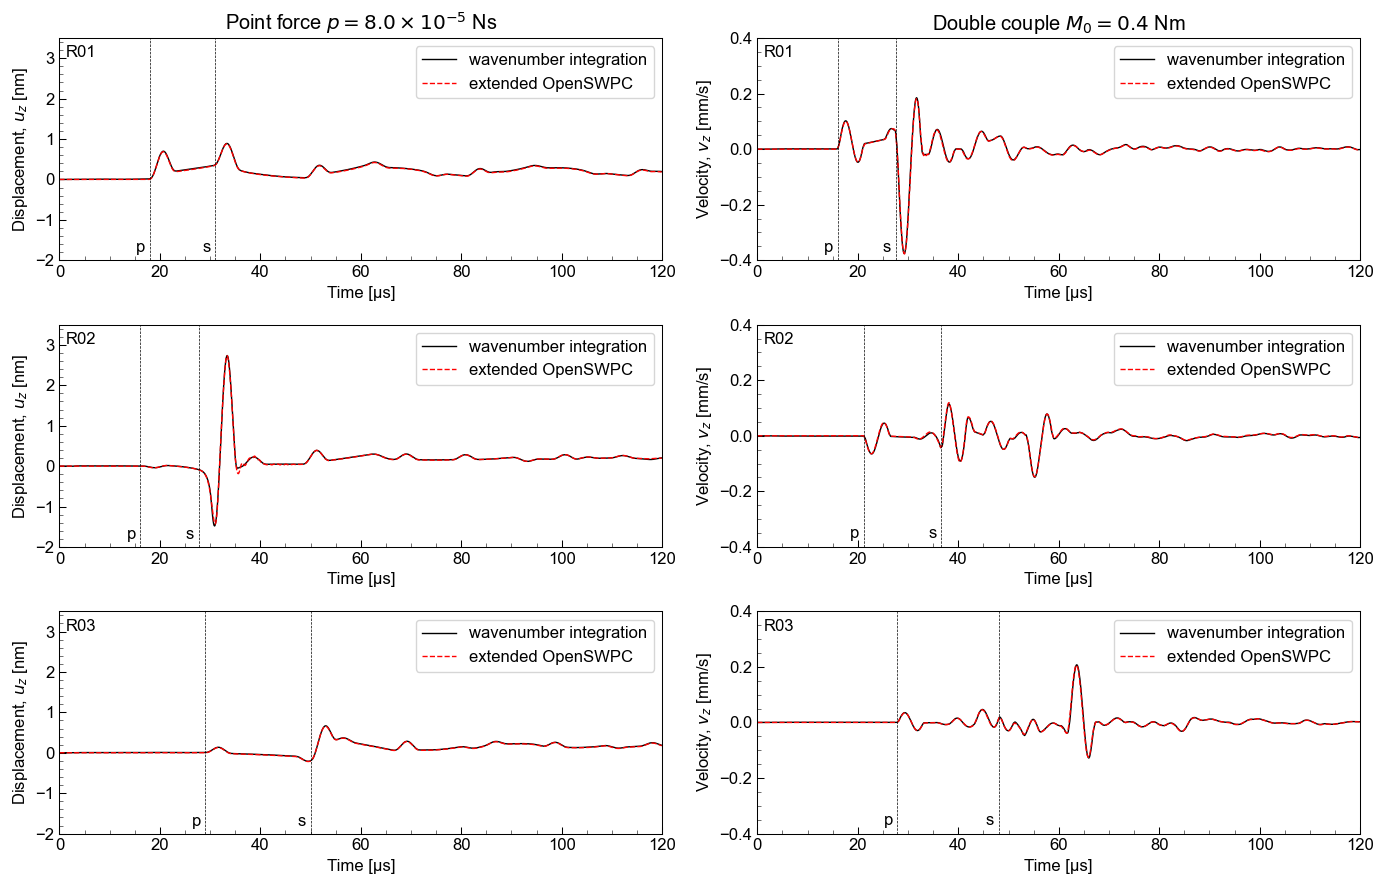

In [23]:

fig, axs = plt.subplots(3, 2, figsize=(14,9), sharex=False)

# ylimit_bf= [[-0.3, 1.0], [-2, 3.5], [-0.3, 1.0]]
ylimit_bf= [[-2, 3.5], [-2, 3.5], [-2, 3.5]]

# ylimit_dc= [[-0.4, 0.4], [-0.2, 0.2], [-0.2, 0.2]]
ylimit_dc= [[-0.4, 0.4], [-0.4, 0.4], [-0.4, 0.4]]

for i in range(3):
    
    # plot bd
#     axs[i, 0].plot((st_hsu_bf[i].times())*1e6, st_hsu_bf[i].data*1e9, "g-.", lw=1, label="Generalized Ray Theory")
    axs[i, 0].plot((st_herrmann_bf[i].times())*1e6, st_herrmann_bf[i].data*1e9, "k-", lw=1, label="wavenumber integration")
    axs[i, 0].plot(st_swpc_bf[i].times()*1e6, -st_swpc_bf[i].data, "r--", lw=1, label="extended OpenSWPC") # flip sign so that downwards positive 

    axs[i, 0].set_xlim([0, 120])
    axs[i, 0].set_ylim(ylimit_bf[i])
    axs[i, 0].set_xlabel("Time [μs]")
    axs[i, 0].set_ylabel("Displacement, $u_z$ [nm]")

    axs[i, 0].legend(loc=1)
    
    # plot dc
    axs[i, 1].plot((st_herrmann_dc[i].times())*1e6, st_herrmann_dc[i].data*1e3, "k-", lw=1, label="wavenumber integration") # [mm/s]
    axs[i, 1].plot(st_swpc_dc[i].times()*1e6, -st_swpc_dc[i].data/1e6, "r--", lw=1, label="extended OpenSWPC") # flip sign so that downwards positive 

    axs[i, 1].set_xlim([0, 120])
    axs[i, 1].set_ylim(ylimit_dc[i])
    axs[i, 1].set_xlabel("Time [μs]")
    axs[i, 1].set_ylabel("Velocity, $v_z$ [mm/s]")    
    axs[i,1].legend(loc=1)

    # plot p and s arrival time
    tp_bf = (st_swpc_bf[i].dist/cp_rock)*1e6
    ts_bf = (st_swpc_bf[i].dist/cs_rock)*1e6
    tp_dc = (st_swpc_dc[i].dist/cp_rock)*1e6
    ts_dc = (st_swpc_dc[i].dist/cs_rock)*1e6
    
    axs[i, 0].axvline(tp_bf, ls="--", c="k", lw=0.5)
    axs[i, 0].axvline(ts_bf, ls="--", c="k", lw=0.5)
    axs[i, 0].text(tp_bf, ylimit_bf[i][0]+0.12, "p ", rotation=0, ha="right", va="bottom")
    axs[i, 0].text(ts_bf, ylimit_bf[i][0]+0.12, "s ", rotation=0, ha="right", va="bottom")

    axs[i, 1].axvline(tp_dc, ls="--", c="k", lw=0.5)
    axs[i, 1].axvline(ts_dc, ls="--", c="k", lw=0.5)
    axs[i, 1].text(tp_dc, ylimit_dc[i][0]+0.02, "p ", rotation=0, ha="right", va="bottom")
    axs[i, 1].text(ts_dc, ylimit_dc[i][0]+0.02, "s ", rotation=0, ha="right", va="bottom")

    # annotate
    axs[i, 0].text(0.01, 0.9, st_herrmann_dc[i].stats.station, ha='left', va='bottom', transform=axs[i, 0].transAxes)
    axs[i, 1].text(0.01, 0.9, st_herrmann_dc[i].stats.station, ha='left', va='bottom', transform=axs[i, 1].transAxes)
    

titleval = "{:.1e}".format(Ft).split("e")[0] + " \\times " + f"10^{{{int(r"{:.1e}".format(Ft).split("e")[1])}}}"

axs[0, 0].set_title(r"Point force $p={}$ Ns".format(titleval))
axs[0, 1].set_title(r"Double couple $M_0={:.1f}$ Nm".format(M0))

fig.tight_layout()

foname = figdir+"/cross-verification_waveform_Herrmann96.png"
plt.savefig(foname, dpi=300)

foname = figdir+"/FigS_cross-verification_waveform_Herrmann96.eps"
plt.savefig(foname)

# Evaluate the error

We evaluate with the difference in peak amplitude at P wave.

0.10200013790988285 0.10034287 1.6516052961847452 0.001892972770585684
0.06503857173199785 0.06475899 0.43172080176415534 0.0027984105028607564
0.03531941910796871 0.034706783 1.7651781967203608 0.0007811067781236851


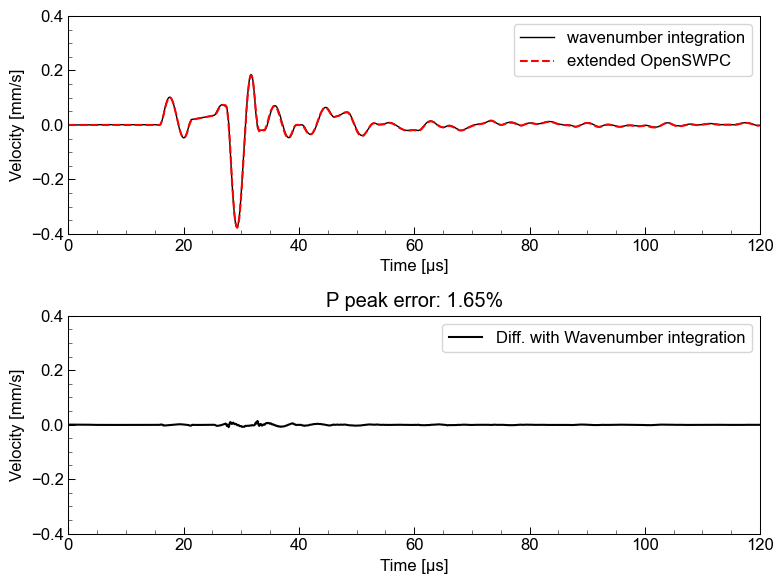

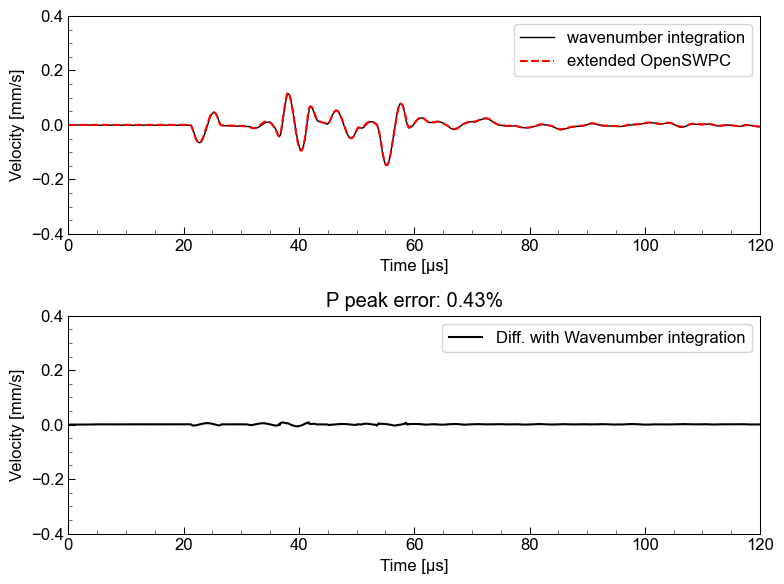

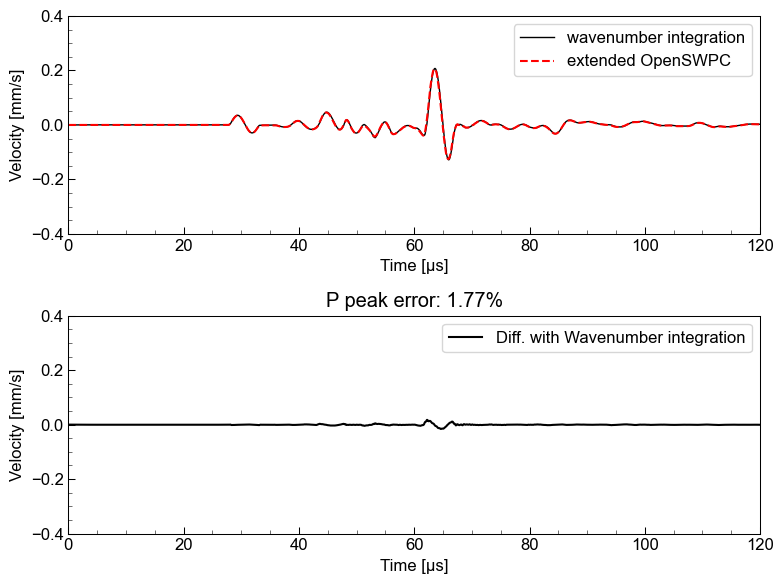

In [24]:
for i in range(3):
    fig, axs = plt.subplots(2, 1, figsize=(8,6), sharex=False)
    
    axs[0].plot((st_herrmann_dc[i].times())*1e6, st_herrmann_dc[i].data*1e3, "k-", lw=1, label="wavenumber integration") # [mm/s]
    axs[0].plot(st_swpc_dc[i].times()*1e6, -1.0*st_swpc_dc[i].data/1e6, "r--", label="extended OpenSWPC")
    axs[1].plot(st_swpc_dc[i].times()*1e6, -st_swpc_dc[i].data/1e6 - st_herrmann_dc[i].data*1e3, "k-", label="Diff. with Wavenumber integration")
    
    max_herrmann = np.max(np.abs(st_herrmann_dc[i].data*1e3))
    max_swpc = np.max(np.abs(-st_swpc_dc[i].data/1e6))
    maxerror = np.abs(max_swpc-max_herrmann)/max_swpc * 100
    
    p_st = st_swpc_dc[i].dist/cp_rock # P wave arrival time
    p_et = p_st + TR/2
    
    pind_herrmann = np.where( (p_st < st_herrmann_dc[i].times()) & (st_herrmann_dc[i].times() < p_et))[0] # P wave window
    pind_spwc = np.where( (p_st < st_swpc_dc[i].times()) & (st_swpc_dc[i].times() < p_et))[0]
    
    max_P_herrmann = np.max(np.abs(st_herrmann_dc[i].data[pind_herrmann]*1e3))
    max_P_swpc = np.max(np.abs(-st_swpc_dc[i].data[pind_spwc]/1e6))
    max_P_error = np.abs(max_P_swpc-max_P_herrmann)/max_P_swpc * 100
    
    rmse = np.sqrt(np.mean(((st_herrmann_dc[i].data[pind_herrmann]*1e3) - (-st_swpc_dc[i].data[pind_spwc]/1e6)) ** 2))
    
    print(max_P_herrmann, max_P_swpc, max_P_error, rmse)
    
    axs[0].set_xlim([0, 120])
    axs[0].set_ylim(ylimit_dc[i])
    # axs[0].set_xlim([p_st*1e6, p_et*1e6])
    # axs[0].set_ylim([-max_P_herrmann*1.1, max_P_herrmann*1.1])
    axs[0].set_xlabel("Time [μs]")
    axs[0].set_ylabel("Velocity [mm/s]")    
    axs[0].legend(loc=1)
    
    axs[1].set_xlim([0, 120])
    axs[1].set_ylim(ylimit_dc[i])
    axs[1].set_xlabel("Time [μs]")
    axs[1].set_ylabel("Velocity [mm/s]")
    axs[1].set_title("P peak error: {:.2f}%".format(max_P_error))
    axs[1].legend(loc=1)
    fig.tight_layout()
    
    
    foname = figdir+"/cross-verification_error_evaluation_{}.png".format(st_swpc_dc[i].stats.station)
    plt.savefig(foname, dpi=100)

# zoom in

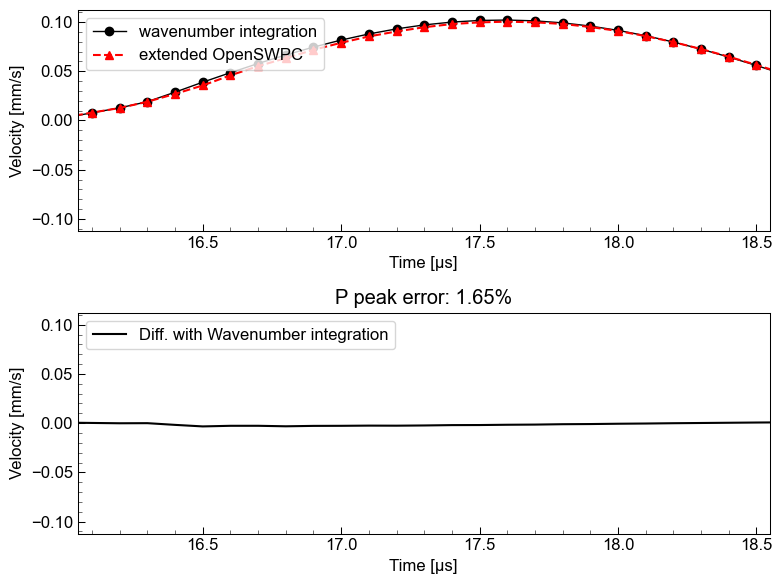

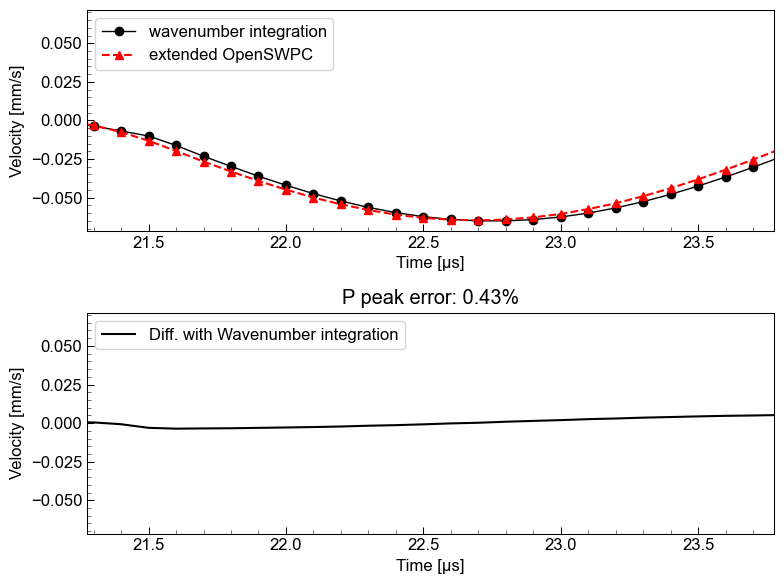

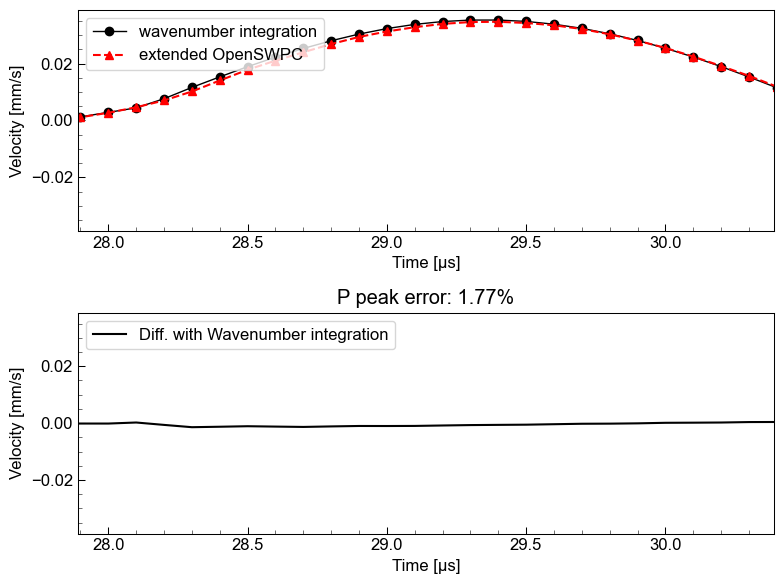

In [25]:
for i in range(3):
    fig, axs = plt.subplots(2, 1, figsize=(8,6), sharex=False)

    axs[0].plot((st_herrmann_dc[i].times())*1e6, st_herrmann_dc[i].data*1e3, "k-o", lw=1, label="wavenumber integration") # [mm/s]
    axs[0].plot(st_swpc_dc[i].times()*1e6, -1.0*st_swpc_dc[i].data/1e6, "r--^", label="extended OpenSWPC")
    axs[1].plot(st_swpc_dc[i].times()*1e6, -st_swpc_dc[i].data/1e6 - st_herrmann_dc[i].data*1e3, "k-", label="Diff. with Wavenumber integration")

    max_herrmann = np.max(np.abs(st_herrmann_dc[i].data*1e3))
    max_swpc = np.max(np.abs(-st_swpc_dc[i].data/1e6))
    maxerror = np.abs(max_swpc-max_herrmann)/max_swpc * 100

    p_st = st_swpc_dc[i].dist/cp_rock # P wave arrival time
    p_et = p_st + TR/2
    
    pind_herrmann = np.where( (p_st < st_herrmann_dc[i].times()) & (st_herrmann_dc[i].times() < p_et))[0] # P wave window
    pind_spwc = np.where( (p_st < st_swpc_dc[i].times()) & (st_swpc_dc[i].times() < p_et))[0]
    
    max_P_herrmann = np.max(np.abs(st_herrmann_dc[i].data[pind_herrmann]*1e3))
    max_P_swpc = np.max(np.abs(-st_swpc_dc[i].data[pind_spwc]/1e6))
    max_P_error = np.abs(max_P_swpc-max_P_herrmann)/max_P_swpc * 100

    # axs[0].set_xlim([62, 66])
    # axs[0].set_ylim(ylimit_dc[i])
    axs[0].set_xlim([p_st*1e6, p_et*1e6])
    axs[0].set_ylim([-max_P_herrmann*1.1, max_P_herrmann*1.1])
    axs[0].set_xlabel("Time [μs]")
    axs[0].set_ylabel("Velocity [mm/s]")    
    axs[0].legend(loc=2)

    # axs[1].set_xlim([62, 66])
    # axs[1].set_ylim(ylimit_dc[i])
    axs[1].set_xlim([p_st*1e6, p_et*1e6])
    axs[1].set_ylim([-max_P_herrmann*1.1, max_P_herrmann*1.1])
    axs[1].set_xlabel("Time [μs]")
    axs[1].set_ylabel("Velocity [mm/s]")
    axs[1].set_title("P peak error: {:.2f}%".format(max_P_error))
    axs[1].legend(loc=2)
    fig.tight_layout()


    foname = figdir+"/cross-verification_error_evaluation_{}_zoom.png".format(st_swpc_dc[i].stats.station)
    plt.savefig(foname, dpi=100)

In [26]:
st_swpc_dc[0].stats

         network: 
         station: R01
        location: 
         channel: Vz
       starttime: 2022-10-18T08:00:00.000000Z
         endtime: 2022-10-18T08:00:00.000120Z
   sampling_rate: 10000000.0
           delta: 1e-07
            npts: 1200
           calib: 1.0
         _format: SAC
             sac: AttribDict({'delta': 1e-07, 'b': 0.0, 'stla': 35.7182, 'stlo': 139.7604, 'stdp': 0.0, 'evla': 35.7182, 'evlo': 139.7604, 'evdp': 0.049999997, 'user0': 0.0, 'user1': 0.0, 'user2': 5e-05, 'user3': -2.500019e-07, 'user4': -2.500019e-07, 'user5': 4.975e-05, 'user6': 139.7604, 'user7': 35.7182, 'user8': 0.0, 'dist': 0.0, 'az': 0.0, 'baz': 0.0, 'gcarc': 0.0, 'cmpaz': 0.0, 'cmpinc': 0.0, 'nzyear': 2025, 'nzjday': 72, 'nzhour': 20, 'nzmin': 13, 'nzsec': 44, 'nzmsec': 0, 'nvhdr': 6, 'npts': 1200, 'iftype': 1, 'idep': 7, 'leven': -1, 'lpspol': 0, 'lovrok': -1, 'lcalda': -1, 'unused23': 0, 'kstnm': 'R01', 'kevnm': '00000001', 'kf': '45  45', 'kcmpnm': 'G_Vz_mxx'})